<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/src/SYN/focus/fb_history.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [1]:
# Choose settings for the parameters part
estimate_parameters=False # to estimate parameters
name_parameters='params_dict_trial_fb_1015' # good for ZIE separated

n=50 # number of threads
h=100 # number of hours considered

## Import

In [3]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

fatal: destination path 'thesis' already exists and is not an empty directory.
Mounted at /content/drive


## Prepare Data

In [4]:
fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
fb=filter_first_h(fb,h)

Filter by year.

In [24]:
fb['created_at'] = pd.to_datetime(fb['created_at'])

fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year
fb['year'].unique()

fb15 = fb[fb['year'] == 2015]
fb14 = fb[fb['year'] == 2014]
fb13 = fb[fb['year'] == 2013]
fb12 = fb[fb['year'] == 2012]
fb11 = fb[fb['year'] == 2011]
fb10 = fb[fb['year'] == 2010]

years = [2010, 2011, 2012, 2013, 2014, 2015]
names = [f'fb{year}' for year in years]
datas = [fb[fb['year'] == year] for year in years]

## Search parameters

In [ ]:
if estimate_parameters:
  params_dict = process_social_platform(names, datas)
  file_path = '/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json'
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as file:
      json.dump(params_dict, file)
else:
  with open('/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json', 'r') as file:
    params_dict = json.load(file)
print(params_dict)

  0%|          | 0/6 [00:00<?, ?it/s]/content/thesis/src/SYN/SYN_package/estimate_parameters.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_comments_by_user_in_thread'].copy()
 17%|█▋        | 1/6 [00:01<00:08,  1.78s/it]/content/thesis/src/SYN/SYN_package/estimate_parameters.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_co

## Simulate synthetic data

In [8]:
n=100
time_intervals = np.arange(0, 1, 0.05)

all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]
    datas_processed_s=[]
    datas_processed_o=[]
    names_processed=[]

    simulated_t, observed_t = simulate_data(df, parameters, activate_tqdm=True, num_threads=n)# peensaree a come limitar i valori dell funzionee IAT senza crear break infiniti
    globals()[f"{social}s_M1"] = simulated_t
    globals()[f"{social}o_M1"] = observed_t
    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M1 = pd.concat(all_dfs, ignore_index=True)



Processing DataFrame: 100%|██████████| 48/48 [00:01<00:00, 44.56it/s]


### Dynamic

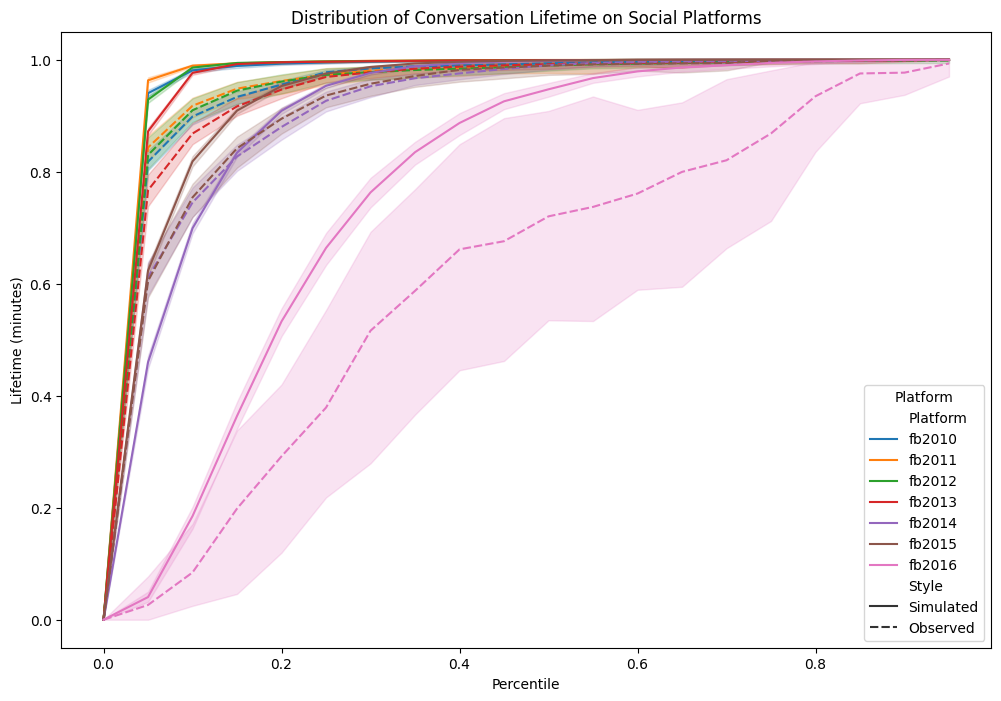

In [10]:
# Prepare data
df_all = df_all_M1.sort_values(by='Style')

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M1, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100))
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

## Participation

100%|██████████| 6/6 [00:00<00:00, 26.24it/s]


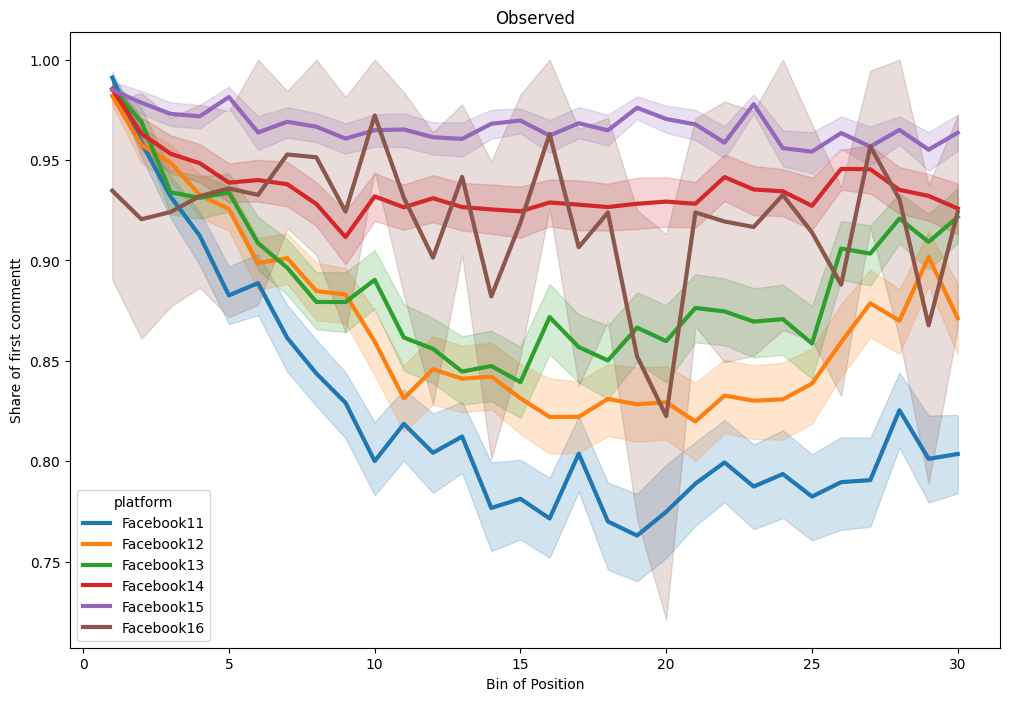

100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


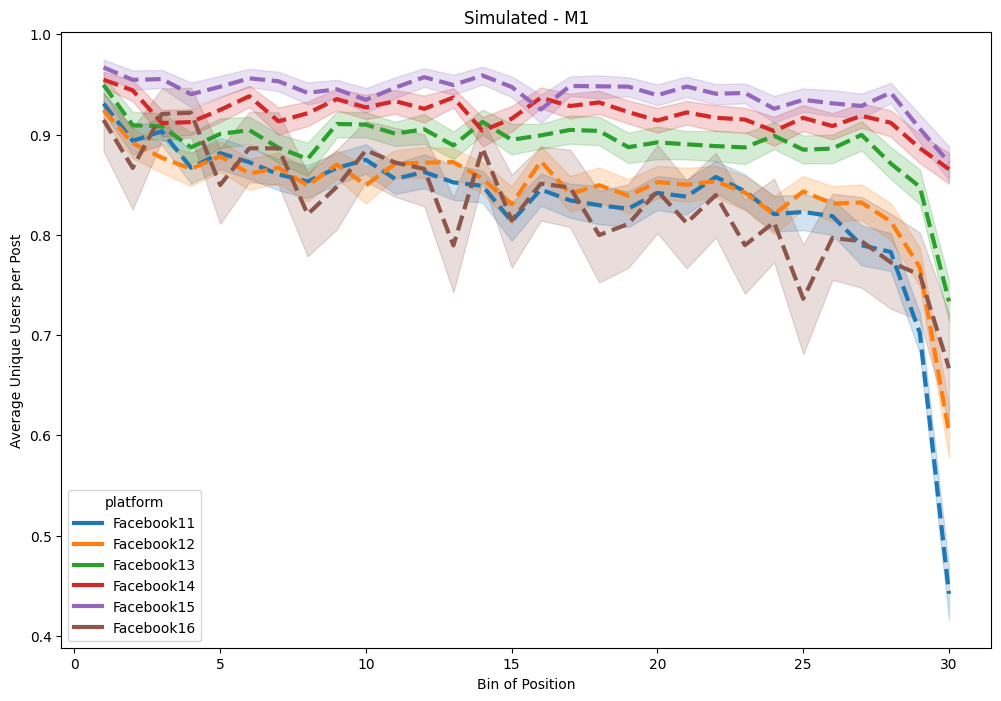

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames
fb2011o_M1['platform'] = 'Facebook11'
fb2012o_M1['platform'] = 'Facebook12'
fb2013o_M1['platform'] = 'Facebook13'
fb2014o_M1['platform'] = 'Facebook14'
fb2015o_M1['platform'] = 'Facebook15'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([fb2011o_M1,fb2012o_M1,fb2013o_M1,fb2014o_M1,fb2015o_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    errorbar=('ci', 80),  # 99.999% confidence interval
    linewidth=3
)
plt.title('Observed')
plt.ylabel('Share of first commentt')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()












import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

fb2011s_M1['platform'] = 'Facebook11'
fb2012s_M1['platform'] = 'Facebook12'
fb2013s_M1['platform'] = 'Facebook13'
fb2014s_M1['platform'] = 'Facebook14'
fb2015s_M1['platform'] = 'Facebook15'

# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([fb2011s_M1,fb2012s_M1,fb2013s_M1,fb2014s_M1,fb2015s_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M1 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M1,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated - M1')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()

